# Disaster Tweet Sentiment Analysis and BERT Application

In today's digital age, social media platforms like Twitter have become vital channels for real-time communication, especially during disasters. Tweets can provide valuable insights into ongoing events, helping organizations and authorities to respond effectively. However, with the vast amount of information shared online, distinguishing between tweets that report actual disasters and those that do not can be challenging.

Disaster Tweet Sentiment Analysis aims to address this challenge by analyzing the sentiment of tweets related to disasters. The goal is to classify tweets into categories that indicate whether they are genuinely reporting a disaster or not. This classification helps in filtering out noise and identifying crucial information that can aid in disaster management and response.

To achieve this, we leverage BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art transformer model developed by Google. BERT has revolutionized Natural Language Processing (NLP) by allowing models to understand the context of words in a sentence more effectively. Unlike traditional models that process text in a unidirectional manner, BERT considers the entire context, both left and right of a word, making it highly effective for text classification tasks like sentiment analysis.

# Table of Content
- Importing Neccesary Packages
- Loading Dataset
- Data Cleaning
- Visualizing the Data
  - Target Dustribution
  - Tweet Length
  - Word Count
  - Word Length
  - Mos Common Words
  - Most Common Bigrams
  - Most Common Trigrams
  - Determining Topics
  - Word Cloud Design
  - Named Entity Recognition
- Building BERT Model
  - Getting Started
  - Tokenization and Formatting the Inputs
  - Bert classification Model
  - Training and Evaluating
  - Prediction

In [3]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011719 sha256=2536bf9673170dff6cf13b59701be4c6d7680b6ef524435d115b9ae0baf952ab
  Stored in directory: /root/.cache/pip/wheels/28/45/a9/c35b2107f053046bd5ac0b1adb5ea970938b02b134e49b9a06
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1


/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.5,<3.8.0
  warnings.warn(warn_msg)


In [4]:
# Loading the train and test data for visualization & exploration.
testv=pd.read_csv('/content/test.csv') # Use read_csv to read in csv files
trainv=pd.read_csv('/content/train.csv')

In [5]:
# Taking general look at the both datasets.

display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [6]:
# Checking observation and feature numbers for train and test data.

print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


# Data Cleaning
Before we visualize our text data I wanted to make it look better with some general helper functions to clear out things like: urls, emojis, html tags, punctuations... We'll add all of them in one column called 'text_clean' then move from there for next steps. When we have cleaner text we can apply our tokenizer to split each word into a token. I'll apply this and next steps to individual columns to show each step of our progress. Next we transforming all words to lowercase then we remove stopwords (they don't mean much in sentence alone) so we use NLTK stopwords for it.
After removing these words we gonna lemmatize them but for that we need to add some extra steps to do it properly: We gonna apply part of speech tags to our text (like verb, noun etc.) then we convert them to wordnet format and finally we can apply lemmatizer and save it to 'lemmatized' column. And one last thing we convert these tokenized lists back to str version for future uses.

So basically what we did are:
- Removed urls, emojis, html tags and punctuations,

- Tokenized the tweet base texts,

- Lower cased clean text,

- Removed stopwords,

- Applied part of speech tags,

- Converted part of speeches to wordnet format,

- Applying word lemmatizer,

- Converted tokenized text to string again.

In [7]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [8]:
# Tokenizing the tweet base texts.

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [9]:
# Lower casing clean text.

trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [10]:
# Removing stopwords.

trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [11]:
# Applying part of speech tags.

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [12]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [13]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


# Visualizing the Data

Target Distribution

When we check our target variables and look at how they disturbuted we can say it not bad. There is no huge difference between classes we can say it's good sign for modelling.

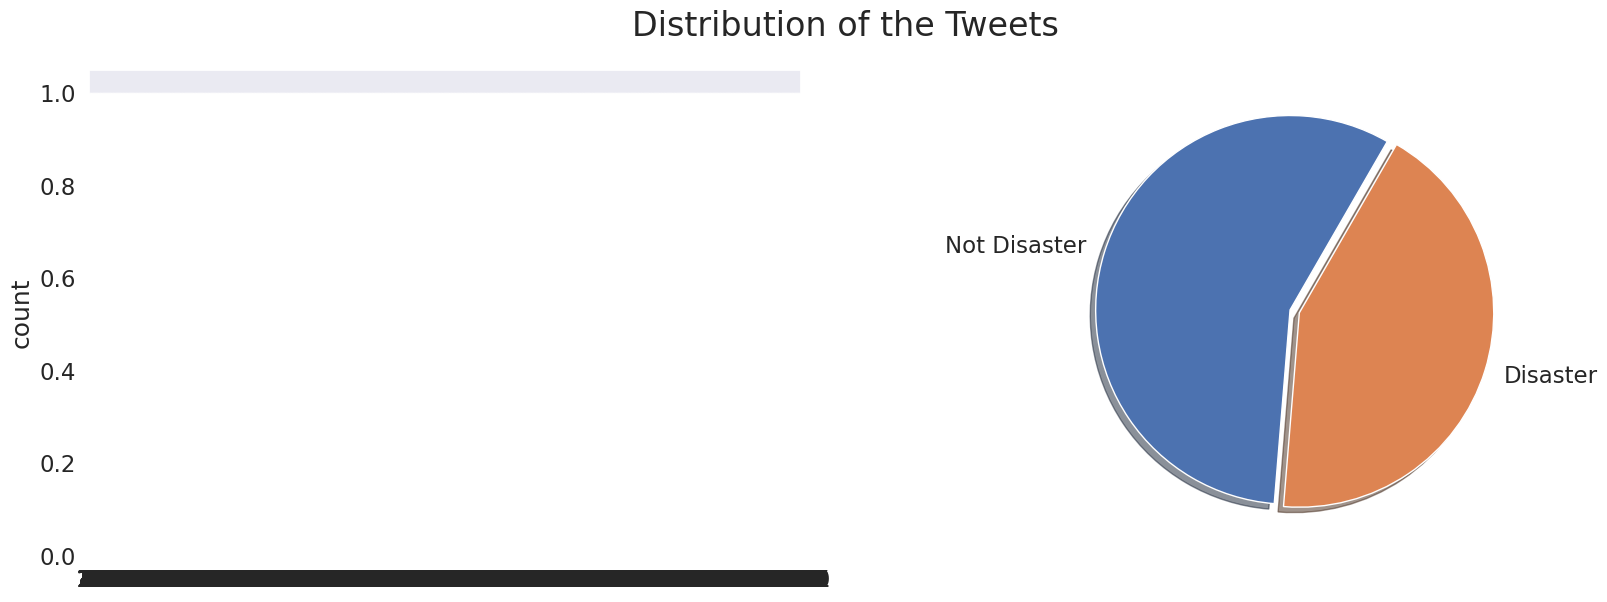

In [14]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['target'], ax=axes[0])
axes[1].pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            #autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

Tweet Lengths

Let's start with the number of characters per tweet and compare if it's disaster related or not. It seems disaster tweets are longer than non disaster tweets in general.

In [15]:
# Creating a new feature for the visualization.

trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

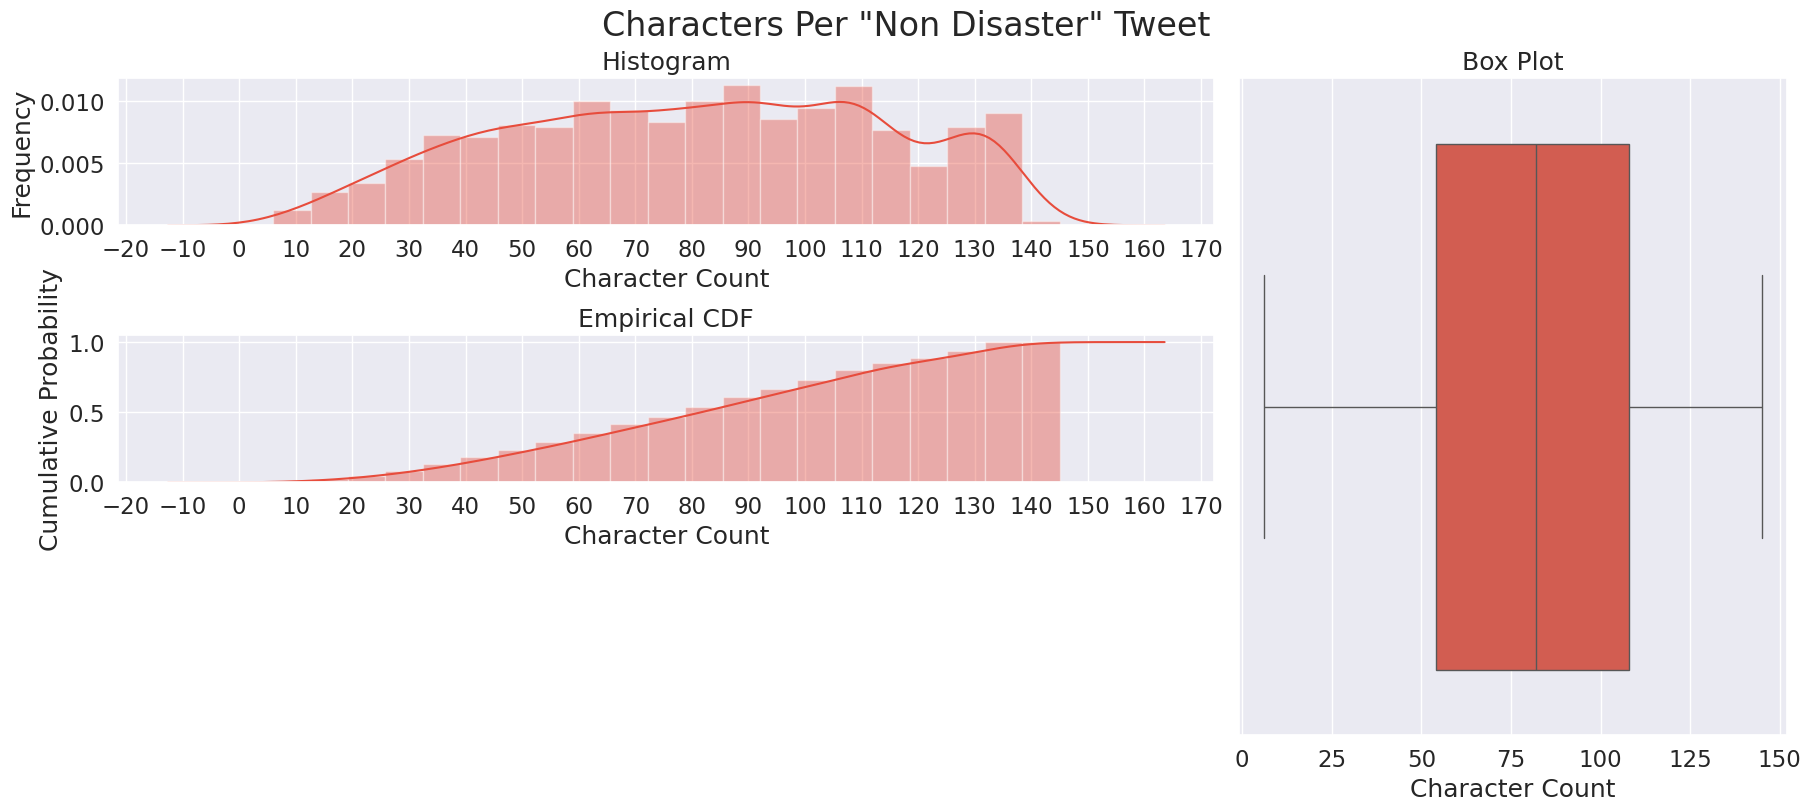

In [16]:
plot_dist3(trainv[trainv['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

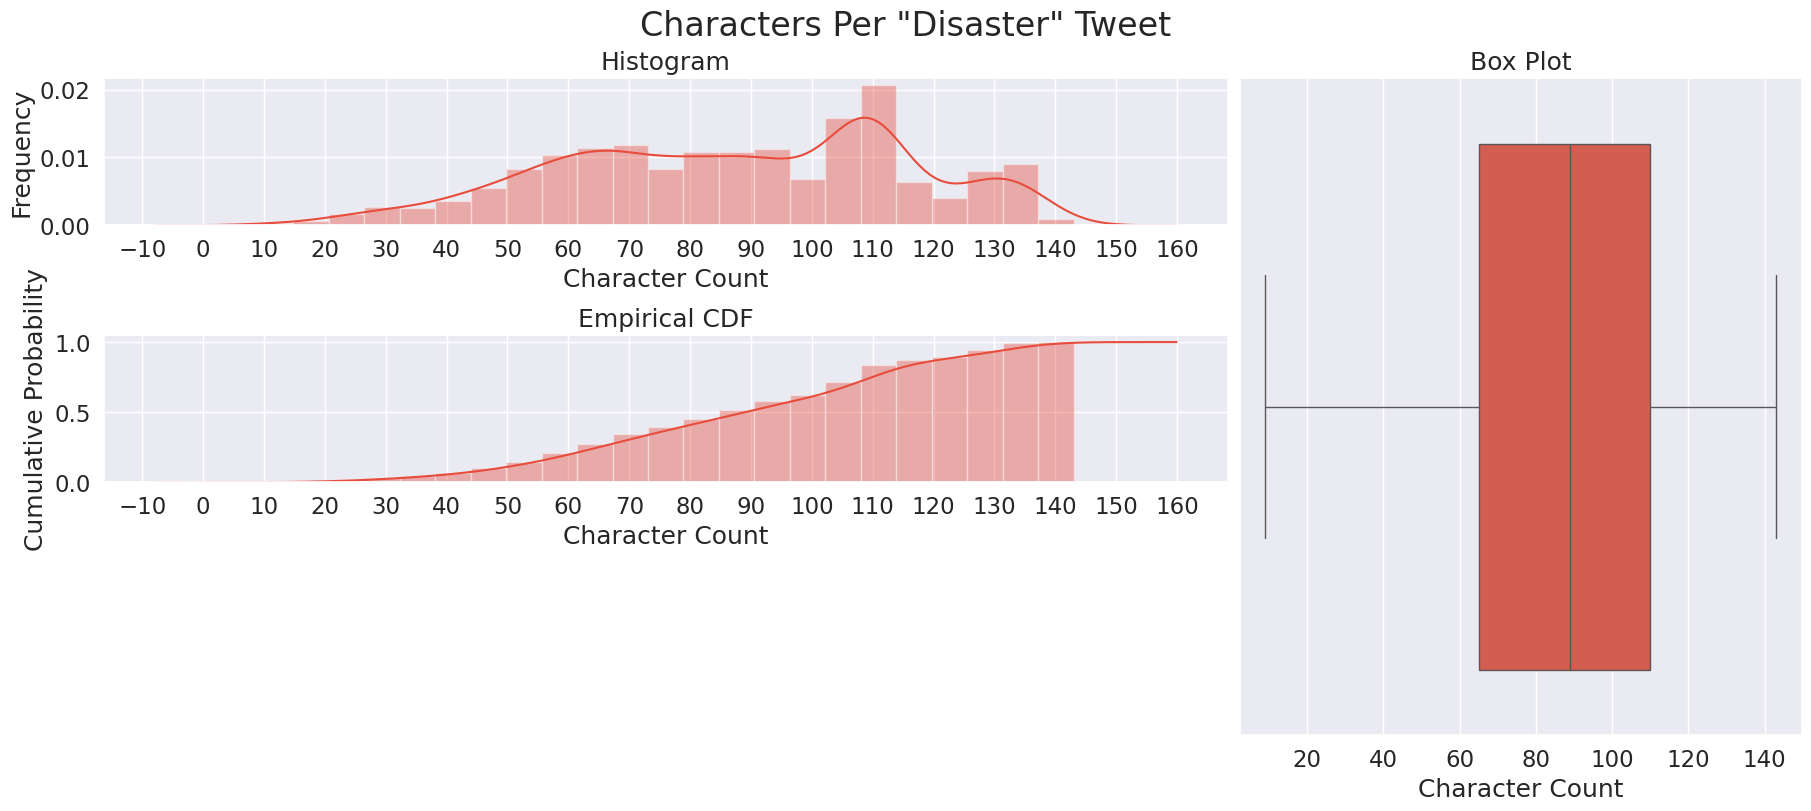

In [16]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [17]:
# word count
def plot_word_number_histogram(textno, textye):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')

    fig.tight_layout()

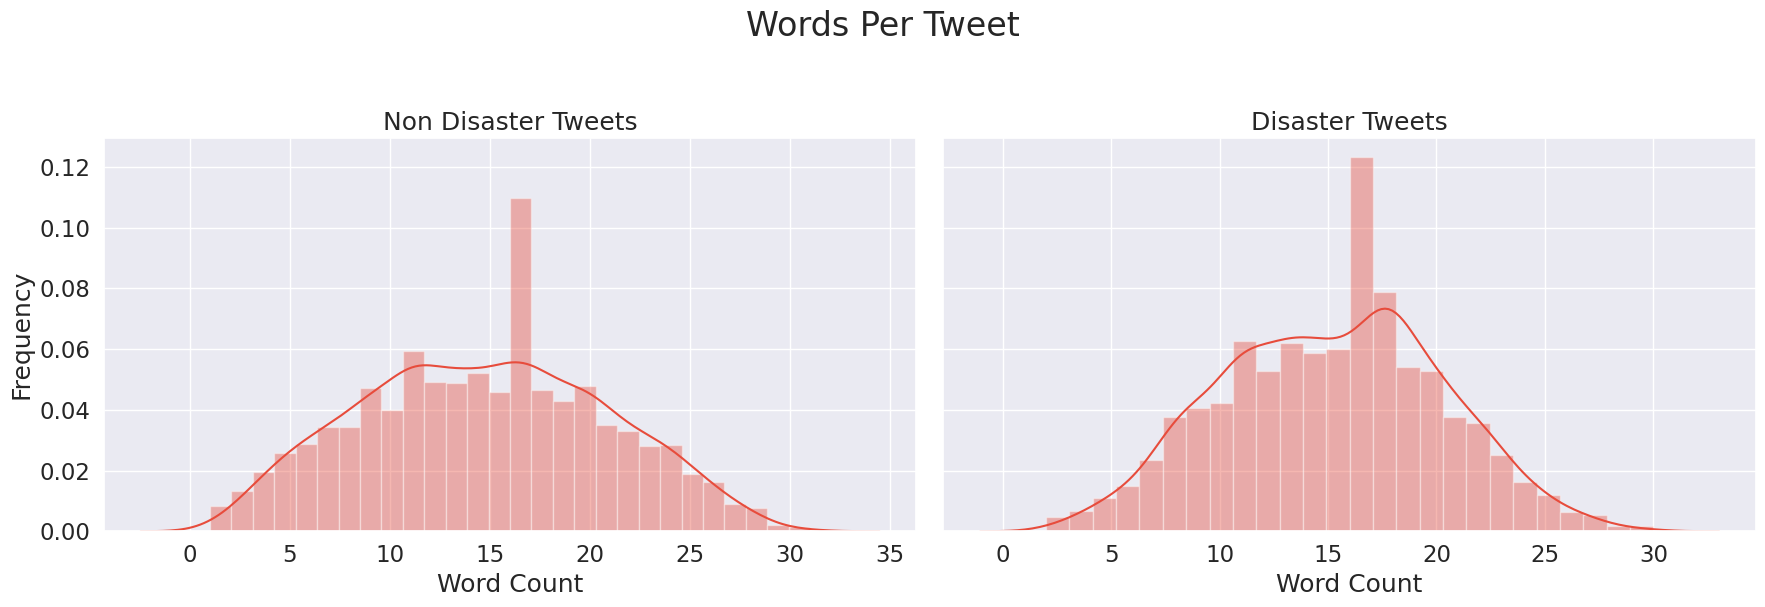

In [18]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],
                           trainv[trainv['target'] == 1]['text'])

In [19]:
# word length
def plot_word_len_histogram(textno, textye):

    """A function for comparing average word length"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()


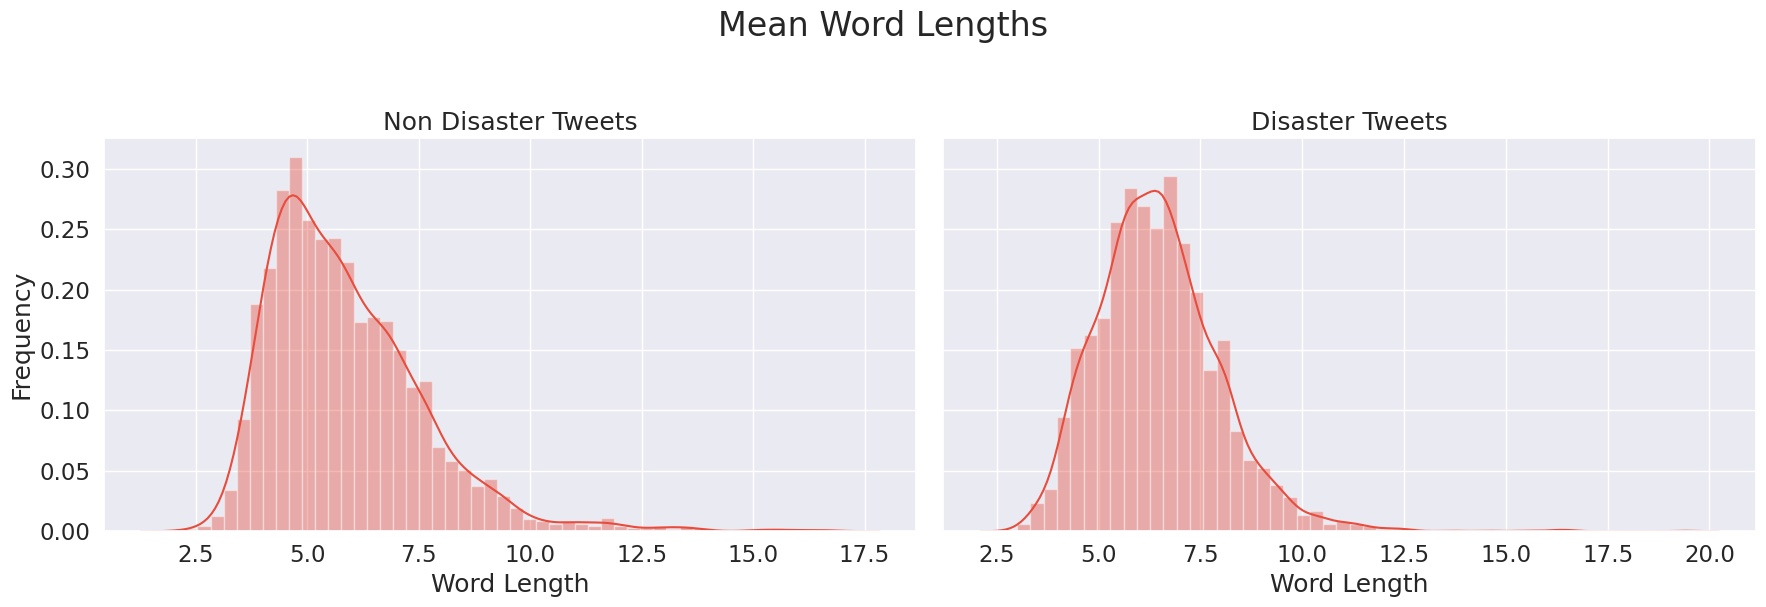

In [20]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'],
                        trainv[trainv['target'] == 1]['text'])


In [21]:
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


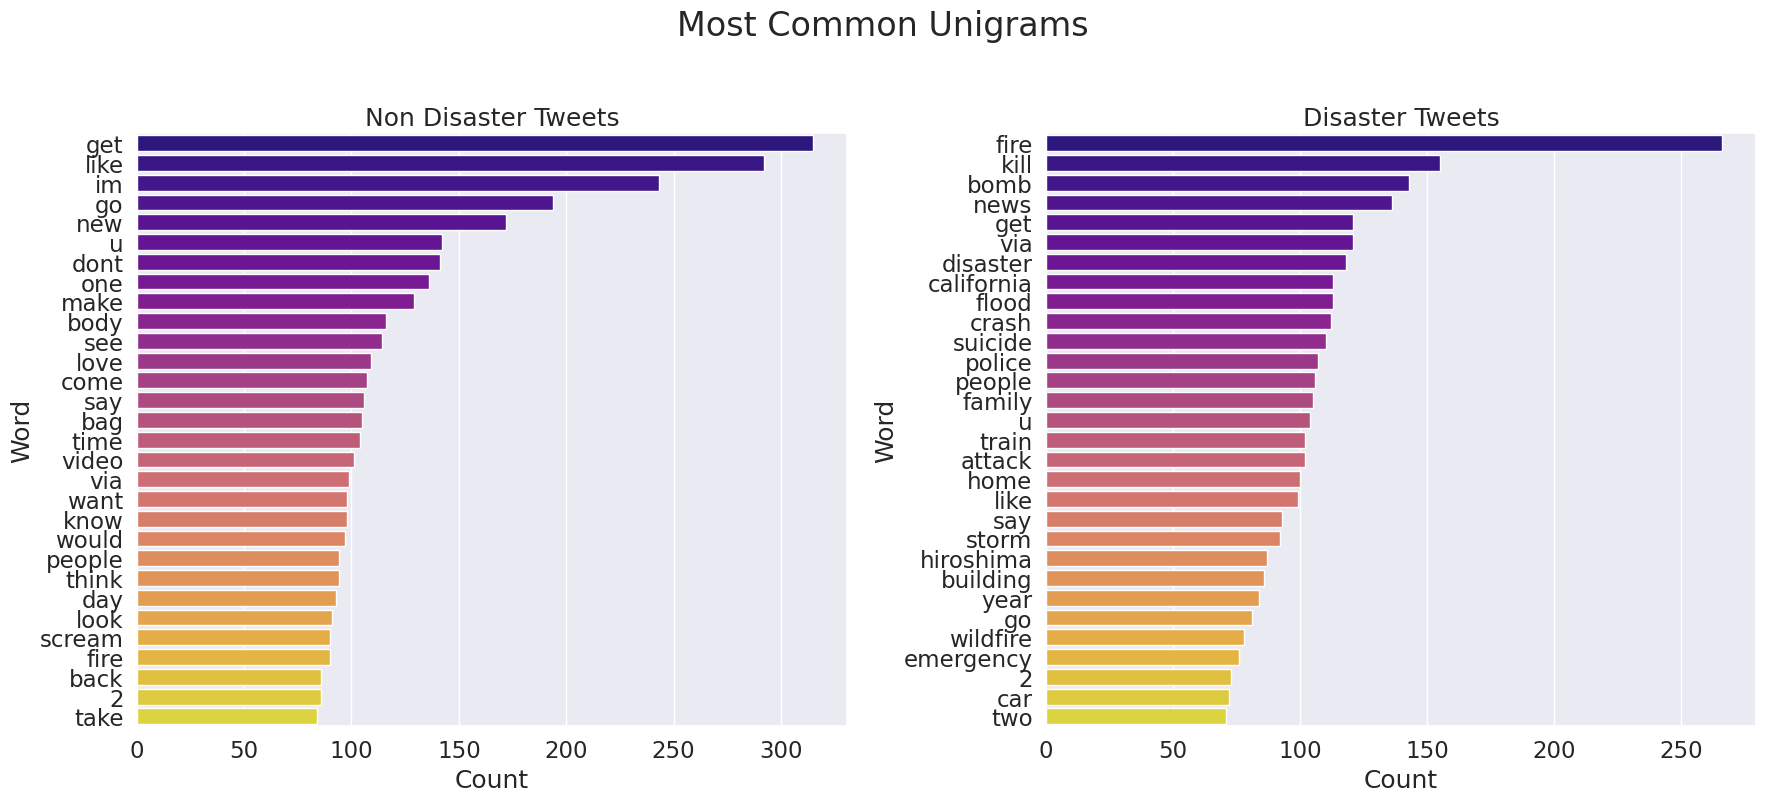

In [23]:
# Most Common Words
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [24]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

Most Common Bigrams

Let's have a look for bigrams this time, which they are sequences of adjacent two words. Again it's pretty obvious to seperate two classes if it's disaster related or not. There are some confusing bigrams in non disaster ones like body bag, emergency service etc. which needs deeper research but we'll leave it here since we got what we looking for in general.

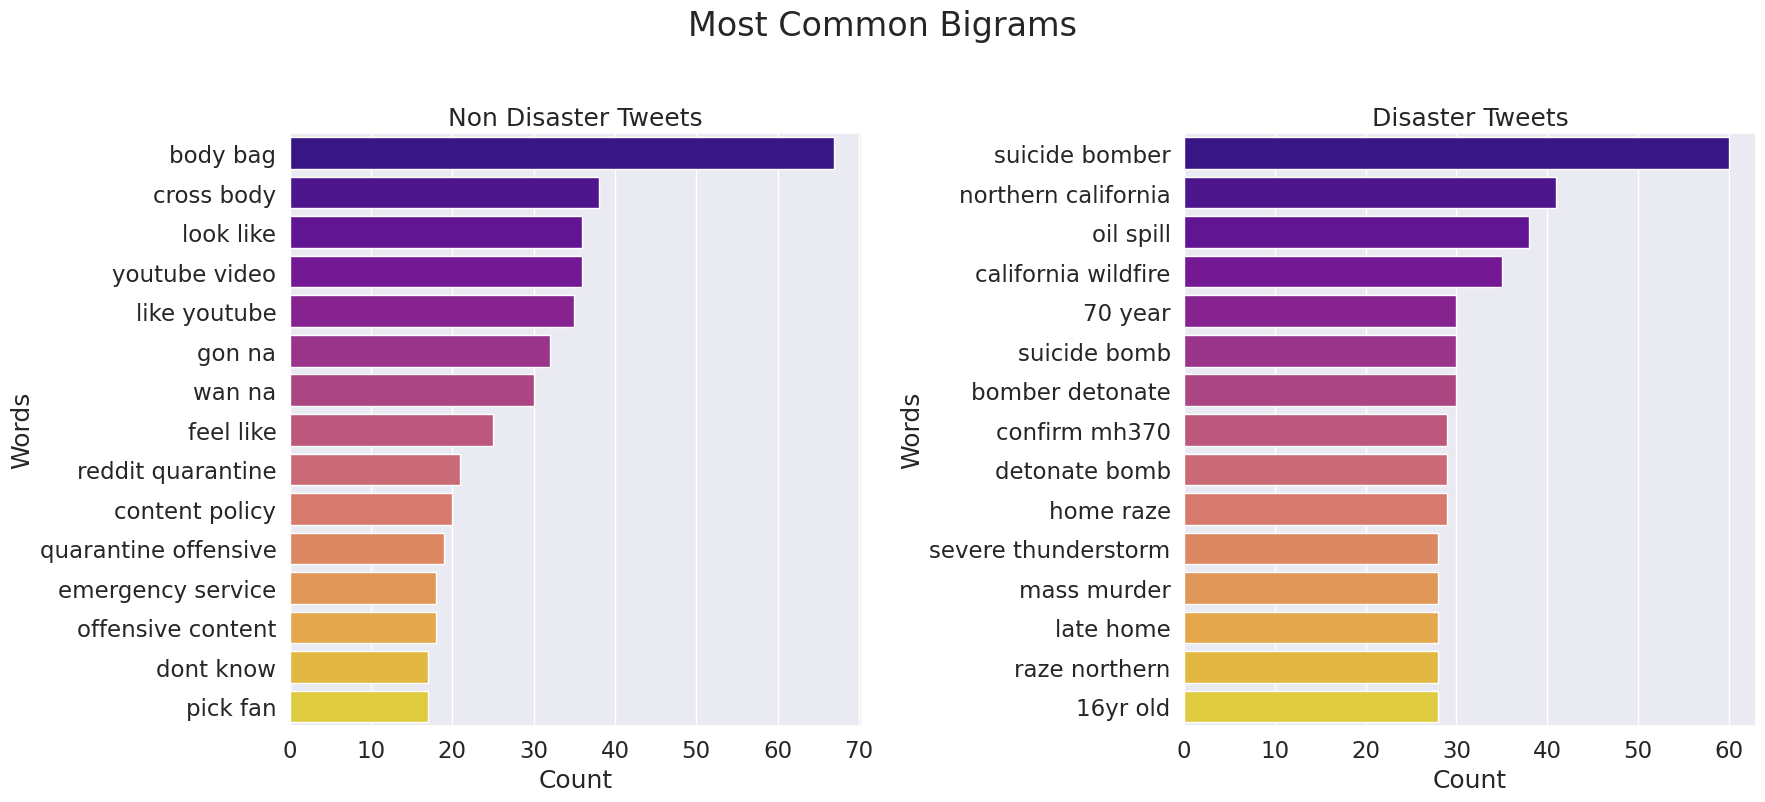

In [25]:
ngrams(2, 'Most Common Bigrams')

Most Common Trigrams

Things are much clearer with sequences of 3 words. The confusing body bags were cross body bags (Who uses them in these days anyways!) which I found it pretty funny when I found the reason of the confusion. Anyways we can see disasters are highly seperable now from non disaster ones, which is great

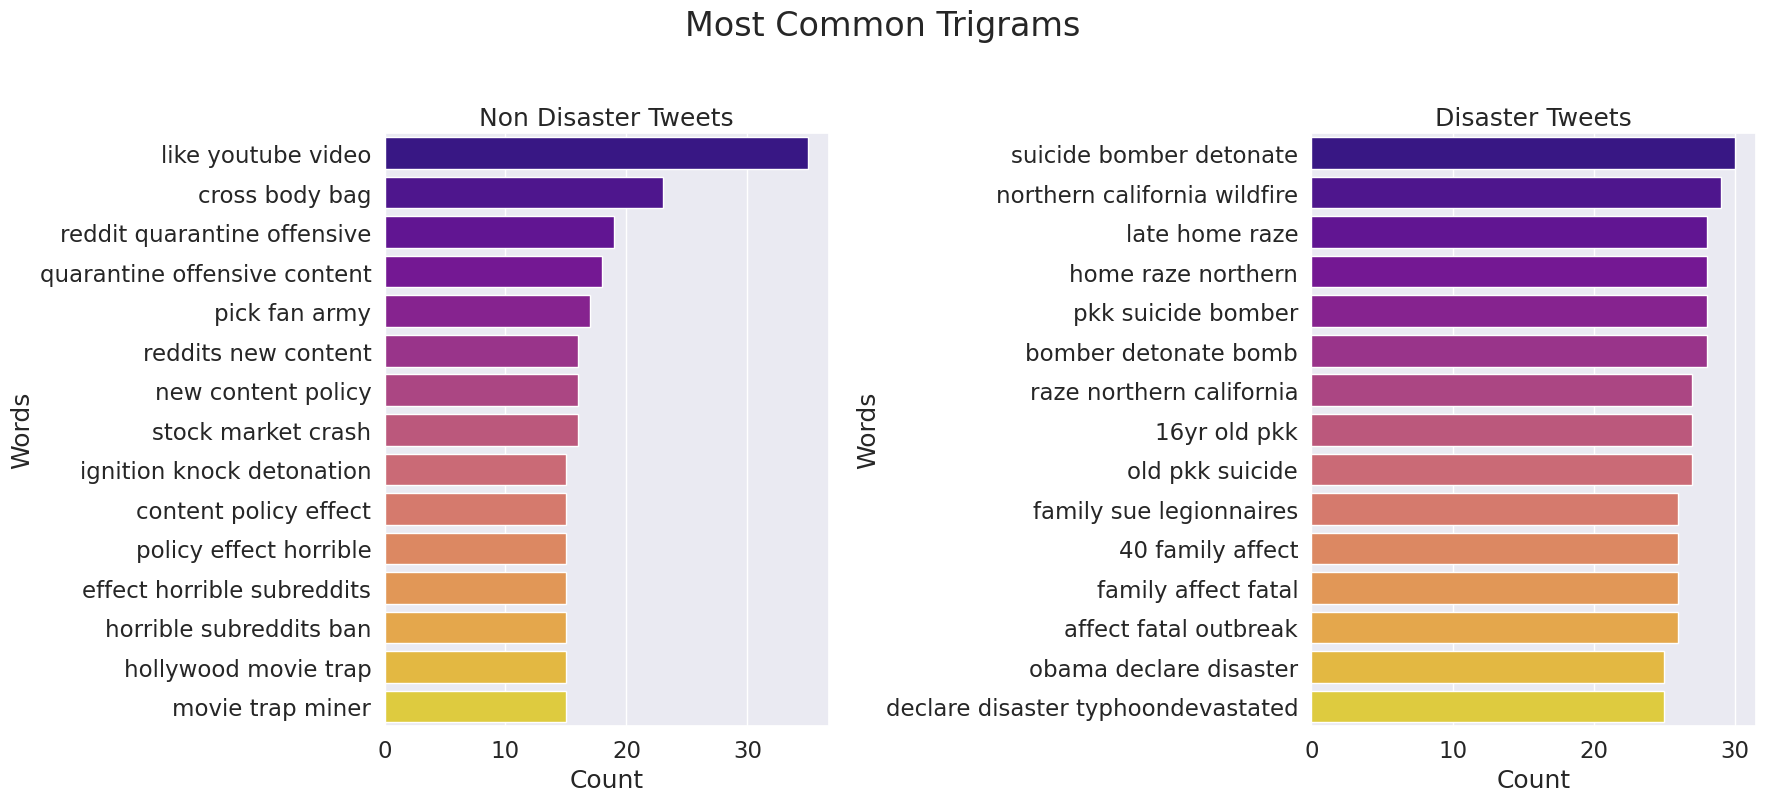

In [26]:
ngrams(3, 'Most Common Trigrams')

Determining Topics

We'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics.


When we inspect our top ten topics we might need to use little imagination to help us understand them. Well actually they are pretty seperable again, I'd say disaster topics are much more clearer to read, we can see the topics directly by looking at them, meanwhile non disaster ones are more personal topics...

In [27]:
def display_topics(text, no_top_words, topic):

    """ A function for determining the topics present in our corpus with nmf """

    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    # Use get_feature_names_out() for newer scikit-learn versions
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    # Remove the alpha parameter if using an older scikit-learn version
    nmf = NMF(n_components=10, random_state=0, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'Non Disaster Topics\n')

Non Disaster Topics

Topic 1:
get lol blow good bomb first day demolish someone play
Topic 2:
like video youtube look feel back fire fatality sink mudslide
Topic 3:
im traumatise still disaster na gon attack drown dead weapon
Topic 4:
new emergency full read content post quarantine many storm re
Topic 5:
body bag cross shoulder woman full lady read ebay really
Topic 6:
dont one see know come say make want think fire
Topic 7:
scream fuck phone face good song loud hit baby time
Topic 8:
via youtube god change obliteration news story stop service military
Topic 9:
go content quarantine many explode make reddit let top deluge
Topic 10:
love crush collide woman much death military armageddon would check


In [28]:
display_topics(lis[1], 10,'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest building truck evacuate wild burn service california set
Topic 2:
suicide bomb kill bomber saudi mosque detonate pkk old 16yr
Topic 3:
california wildfire home northern late news raze abc collapse burn
Topic 4:
flood storm rain people train issue severe weather rescue violent
Topic 5:
hiroshima atomic bomb year japan still anniversary 70 war bombing
Topic 6:
via attack wave israeli police evacuation heat post wound car
Topic 7:
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 8:
disaster nuclear obama natural declare saipan typhoondevastated sign collapse northern
Topic 9:
crash kill accident helicopter air train fear say police car
Topic 10:
get watch minute sandstorm swallow airport go im like dont


Word Cloud

Wordclouds are popular approach in NLP tasks. We're going to use the library exactly designed for it called "WordCloud", I also wanted to mask it with twitter logo shape and grey colors just for adding more interesting presentation and show what you can do with this library. When we look our word clouds we can clearly say which one is disaster on which one is not. Pretty good!

In [29]:
mask = np.array(Image.open('/content/twitter.png'))
# Check if the image is grayscale (2D) or color (3D)
if mask.ndim == 2:
    mask[mask == 0] = 255  # Adjust condition for grayscale image
elif mask.ndim == 3:
    mask[mask.sum(axis=2) == 0] = 255  # Original code for color images
else:
    print("Unexpected image dimensions.")

In [30]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

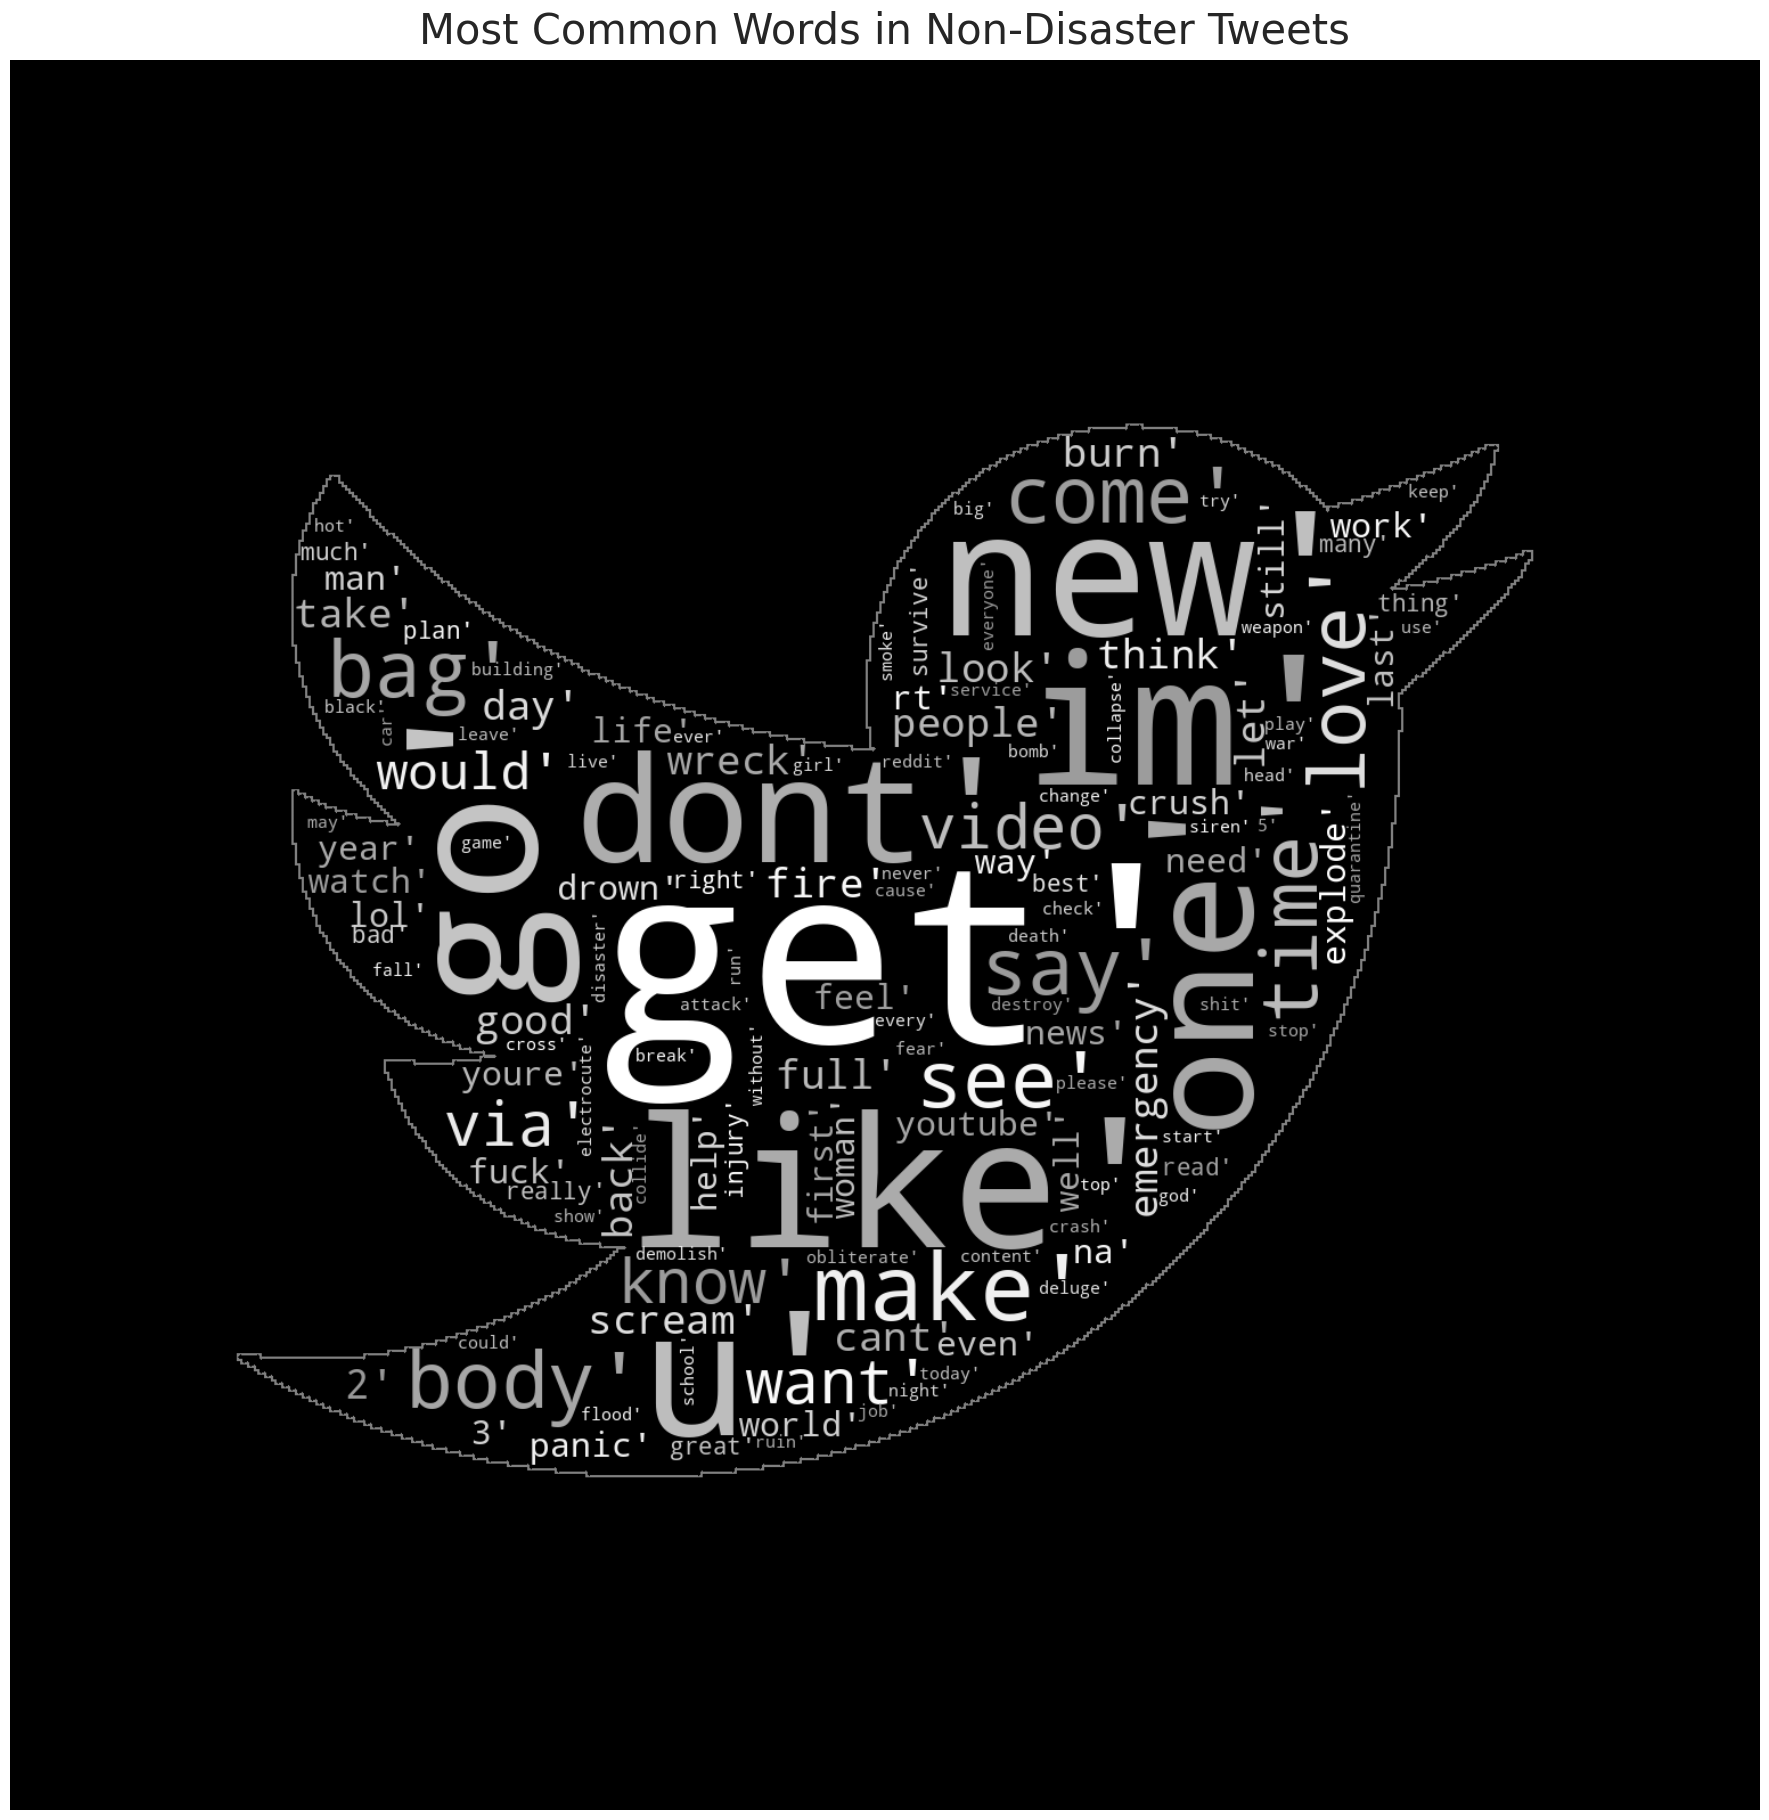

In [31]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

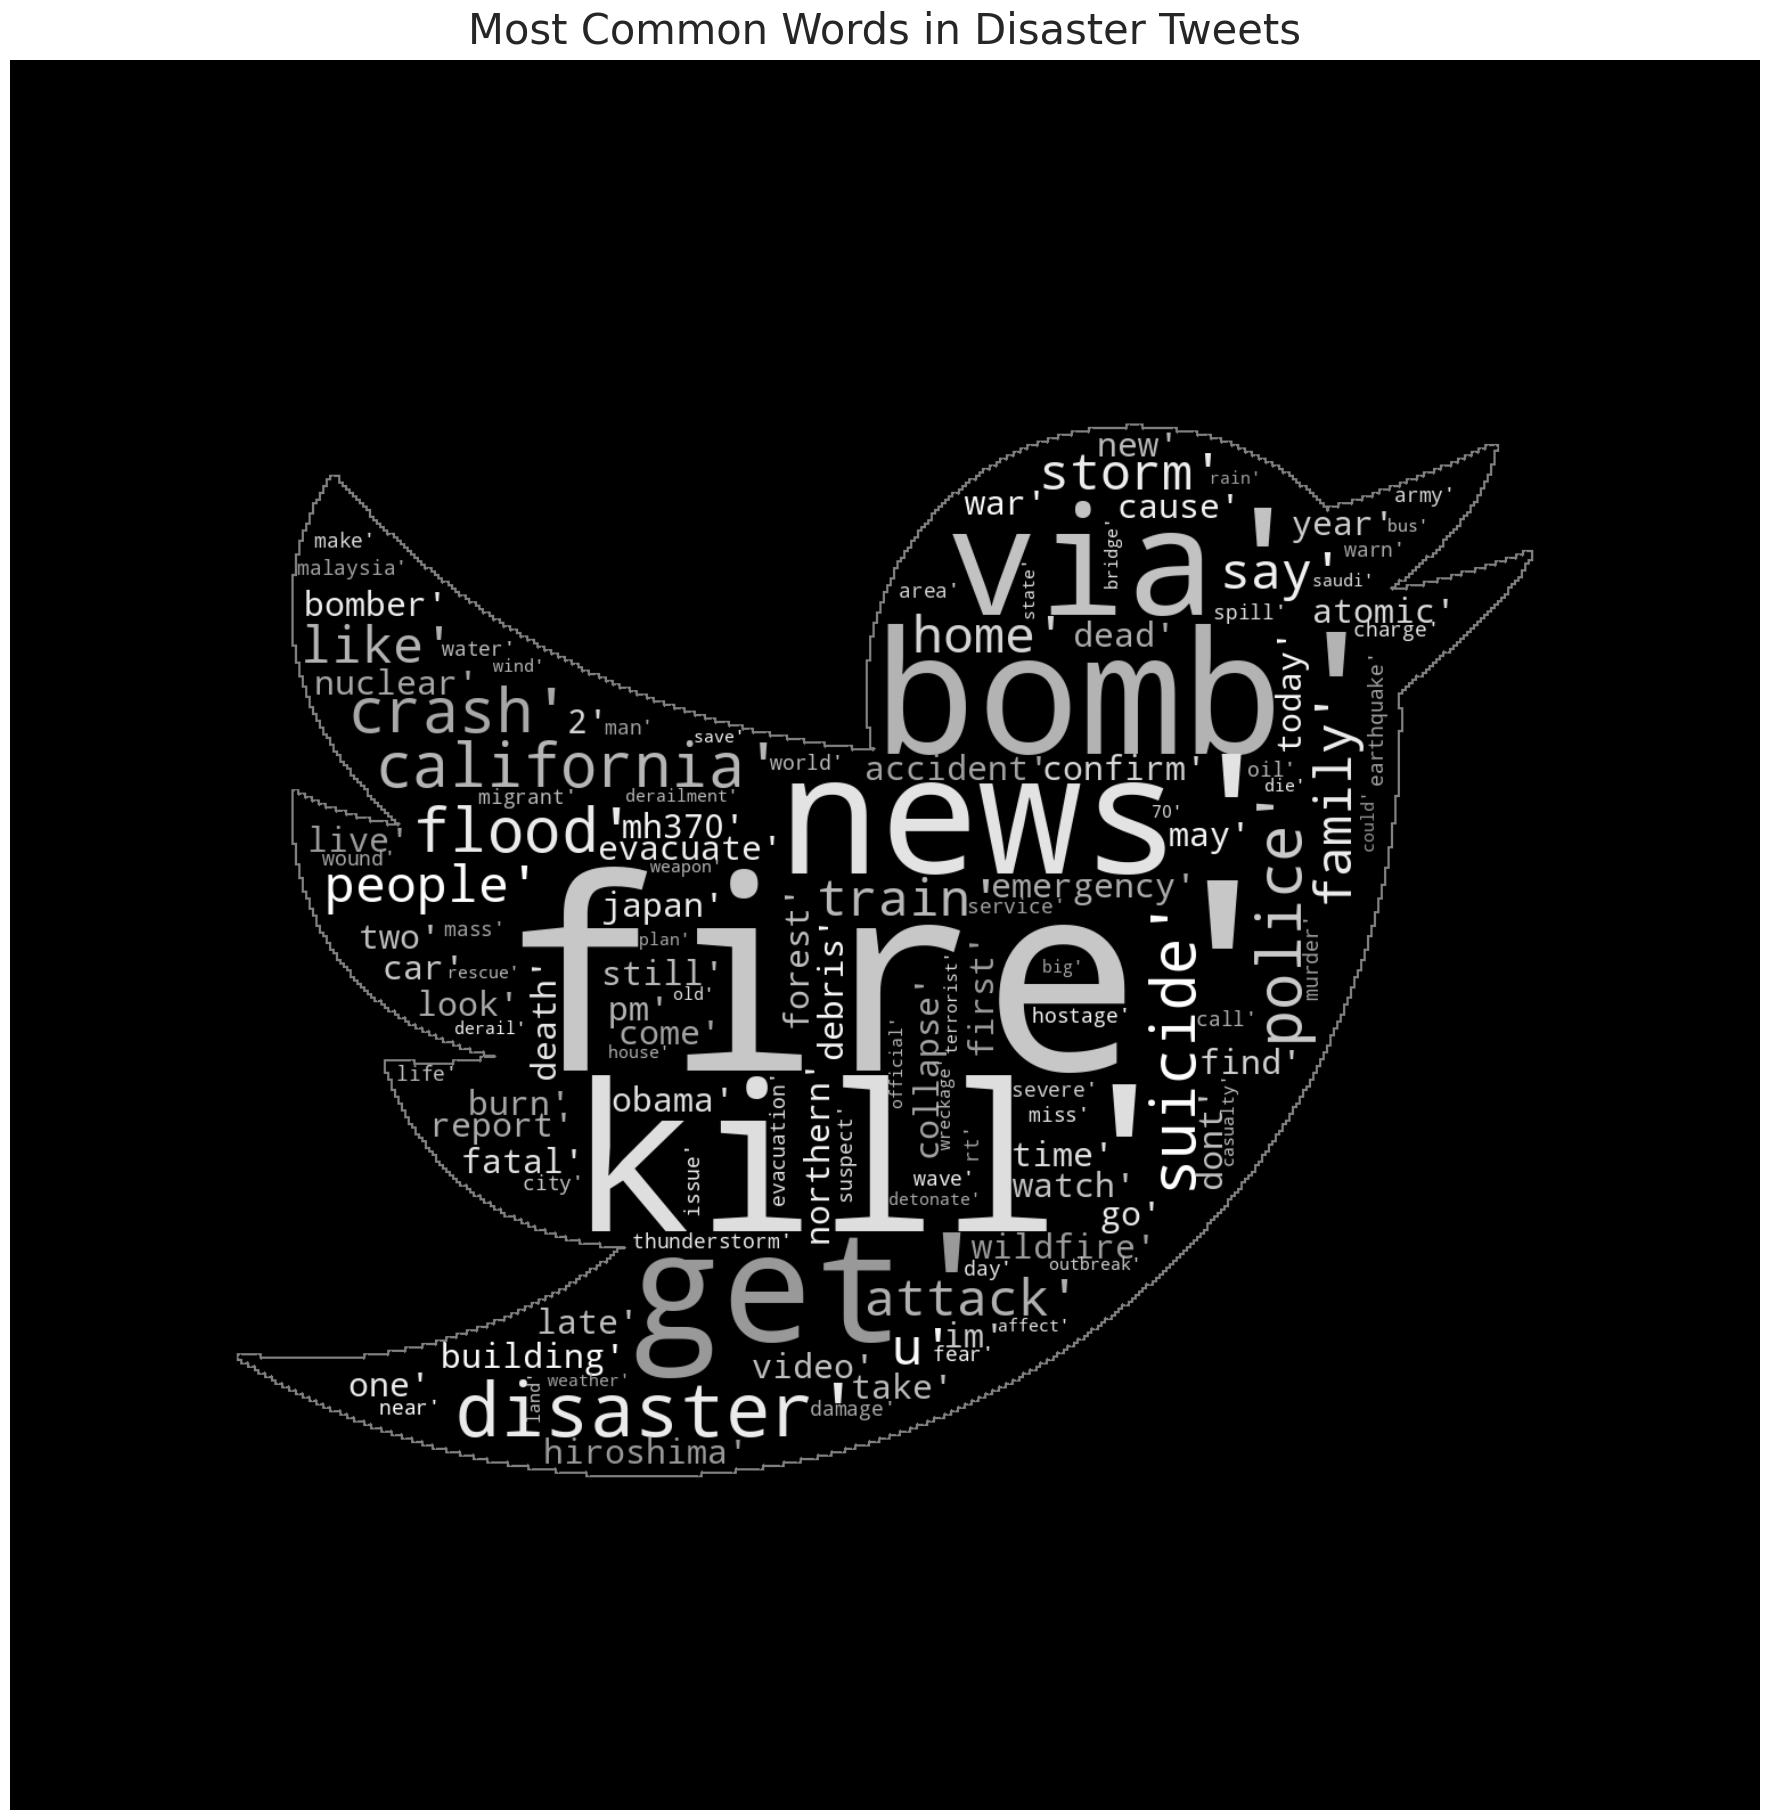

In [32]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)

In [33]:
# Named Entity Recognition

!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
import en_core_web_sm

# Named Entity Recognition
# Loading NER.
nlp = en_core_web_sm.load()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en_core_web_sm 2.2.5
    Uninstalling en_core_web_sm-2.2.5:
      Successfully uninstalled en_core_web_sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [34]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

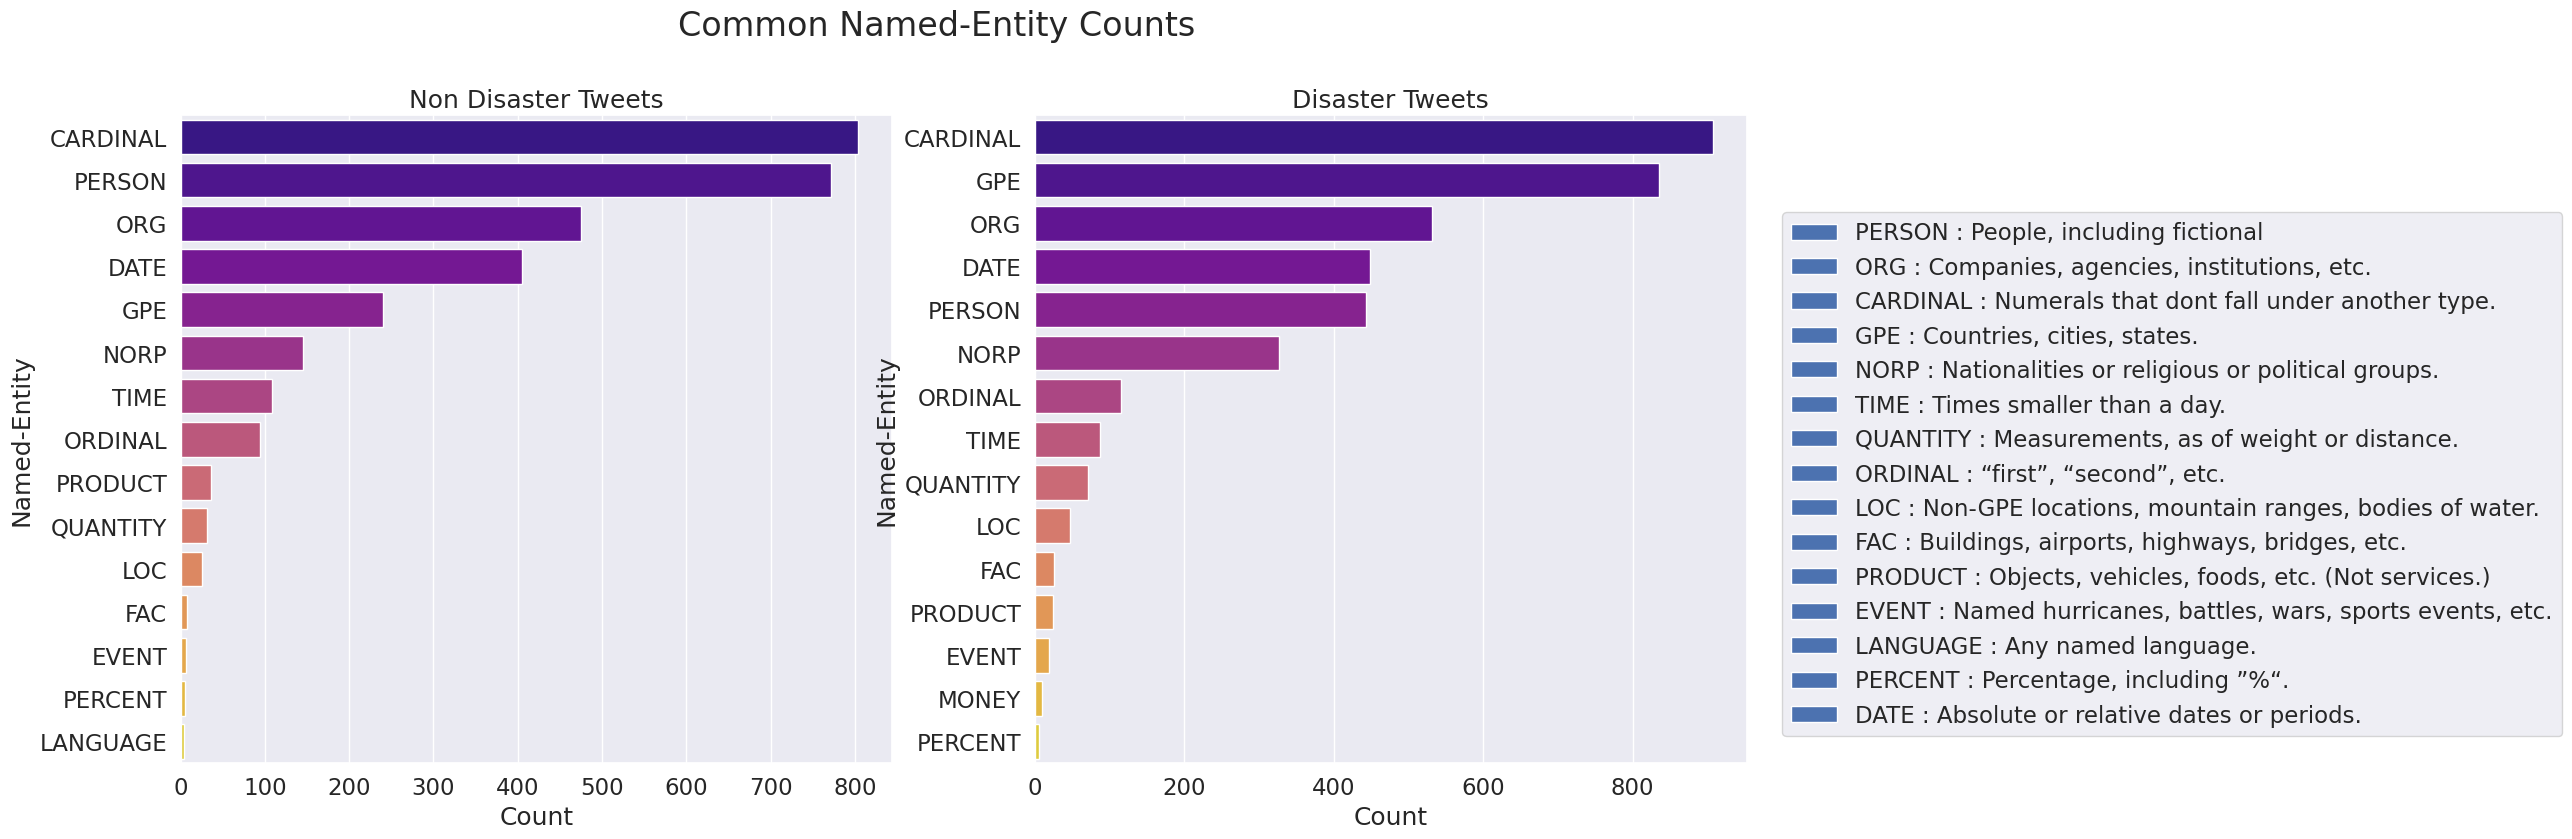

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

Bert Model

Let's start with setting our main computing device. The code below automatically choose GPU if it's available otherwise goes with CPU but I highly recommend GPU which is much faster. Then we load our traning and test data for modelling, as I said I'm not going to use our visualization data, BERT uses punctuations in modelling and as you'll see BERT does great job on raw text by itself.

In [36]:
# If there's a GPU available...

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.

    device = torch.device('cuda')


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

No GPU available, using the CPU instead.


In [37]:
# Loading the train and test data
test=pd.read_csv('/content/test.csv') # Use read_csv to read in csv files
train=pd.read_csv('/content/train.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
217,309,annihilated,"Greater Manchester, UK",@ACarewornHeart Have a good un fella sorry I w...,0
6688,9582,thunder,NaN,Thunder lightening torrential rain and a power...,1
2687,3855,detonation,NaN,Dorman 917-033 Ignition Knock (Detonation) Sen...,1
5060,7211,natural%20disaster,liaÛ¢daniÛ¢laura,Rise up like a natural disaster we take the ba...,0
6855,9826,trauma,NaN,Trauma injuries involving kids and sport usual...,1
563,814,battle,NaN,A young German stormtrooper engaged in the Bat...,1
2431,3493,derailed,United Kingdom,#tubestrike derailed you? Our #robertwelch cut...,0
2928,4209,drowned,NaN,@ABCNews24 @PeterDutton_MP \nHe also told you....,0
3400,4868,explode,London / Berlin / Online,'I eat because it makes my mouth explode with ...,0
6258,8942,storm,NaN,FINALLY a storm,0


In [38]:
# Setting target variables, creating combined data and saving index for dividing combined data later.

labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

Tokenization and Formatting the Inputs¶
For feeding our text to BERT we have to tokenize our text first and then these tokens must be mapped. For this job we gonna download and use BERT's own tokenizer. Thanks to Transformers library it's like one line of code, we also convert our tokens to lowercase for uncased model. You can see how the tokenizer works below there on first row of tweets for example.

We set our max len according to our tokenized sentences for padding and truncation, then we use tokenizer.encode_plus it'll split the sentences into tokens, then adds special tokens for classificication [CLS]:

The first token of every sequence is always a special classification token ([CLS]).

The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. (from the BERT paper)

Then it adds [SEP] tokens for making BERT decide if sentences are related. In our case it shouldn't be that important I think.


Then our tokenizer map's our tokens to their IDs first and pads or truncates all sentences to same length according to our max length. If sentence is longer than our limit it gets truncated, if it's shorter than our defined length then it adds [PAD] tokens to get them in same length.


Finally tokenizer create attention masks which is consisting of 1's and 0's for differentiating [PAD] tokens from the actual tokens.

We do these steps for each train and test set and then get our converted data for our BERT model. We also split train test on our train data for checking our models accuracy.


Lastly we define how to load the data into our model for training, since we can't use it all at once because of memory restrictions. On the official BERT paper batch size of 16 or 32 is recommended so we went with 32 since Kaggle offers us decent GPU's thanks to them!

In [39]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [40]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [41]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [42]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


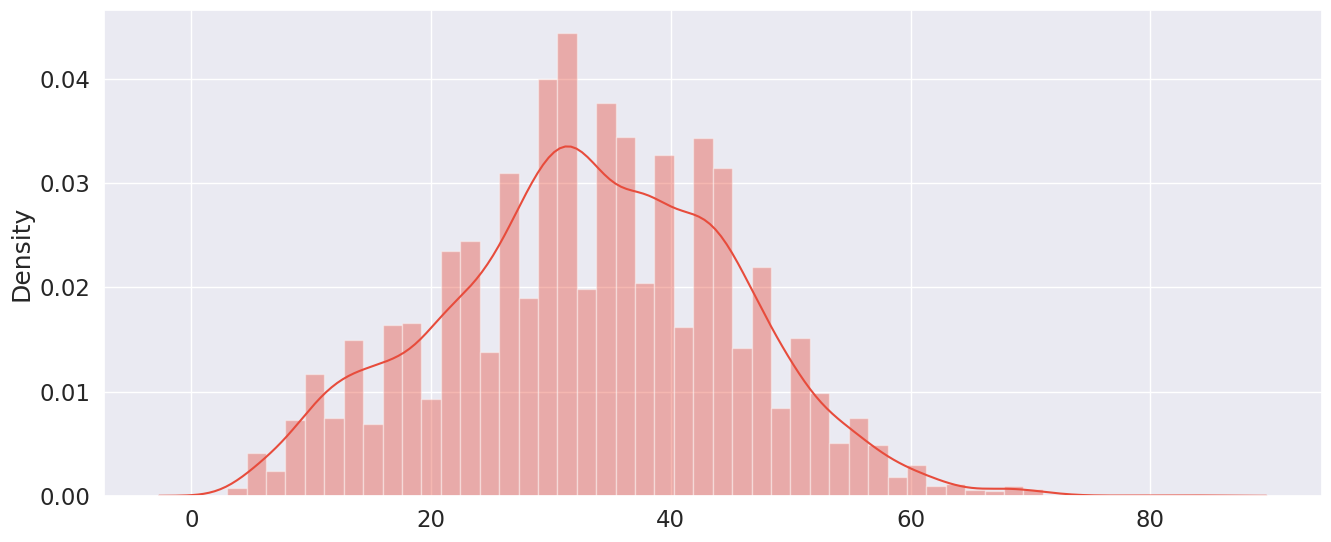

In [43]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [44]:
# Splitting the train test data after tokenizing.

train= combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [45]:
def tokenize_map(sentence,labs='None'):

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [48]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

def tokenize_map(sentence, labs=None): # Change the default to None (without quotes)

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs is not None: # Use 'is not None' for checking if labels were provided
        labels_tensor = torch.tensor(labs) # Create a tensor from the provided labels
        return input_ids, attention_masks, labels_tensor
    else:
        return input_ids, attention_masks

In [50]:
# Combine the training inputs into a TensorDataset.

# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.
input_ids, attention_masks, labels = tokenize_map(train, labels)

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [51]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [53]:
# Tokenize the test data
test_input_ids, test_attention_masks = tokenize_map(test) # Assuming 'test' holds your test sentences

prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [54]:
#Setting the Bert Classification Model
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [55]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [56]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

# The 'W' stands for 'Weight Decay fix' probably...

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [57]:
# Number of training epochs. The BERT authors recommend between 2 and 4.

# We chose to run for 3, but we'll see later that this may be over-fitting the training data.

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training and Evaluating¶
Time to train our model! First we set some helper functions to calculate our metrics and time spent on the process. Then it moves like this, directly from the original notebook, it's pretty good at explaining I shouldn't confuse you with my own way of telling I guess:
Training:

Unpack our data inputs and labels
Load data onto the GPU for acceleration,
Clear out the gradients calculated in the previous pass,
In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out,
Forward pass (feed input data through the network),
Backward pass (backpropagation),
Tell the network to update parameters with optimizer.step(),
Track variables for monitoring progress.
Evalution:

Unpack our data inputs and labels,
Load data onto the GPU for acceleration,
Forward pass (feed input data through the network),
Compute loss on our validation data and track variables for monitoring progress.
Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.

The code below trains according to our data and saves the learning progress on the way so we can summarize at the end and see our results. We can also turn these to dataframe and plot it to see our eavluation better. So we can decide if the model performs well and not overfitting...

In [58]:
def flat_accuracy(preds, labels):

    """A function for calculating accuracy scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):

    """A function for calculating f1 scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [59]:
def format_time(elapsed):

    """A function that takes a time in seconds and returns a string hh:mm:ss"""

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:

    t0 = time.time()

    # Reset the total loss for this epoch.

    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.

    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

    model.train()

    # For each batch of training data...

    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'.
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.

        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)

        loss_value, logits_value = model(b_input_ids,
             token_type_ids=None,
             attention_mask=b_input_mask,
             labels=b_labels).to_tuple()

        # Check the type of the 'loss' variable to ensure it's a tensor
        print(type(loss_value))

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end,
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.

        total_train_loss += loss_value.item()

        # Perform a backward pass to calculate the gradients.

        loss_value.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.

        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)

        optimizer.step()

        # Update the learning rate.

        scheduler.step()

    # Calculate the average loss over all of the batches.

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.

    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    total_t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.

    model.eval()

    # Tracking variables:

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.

    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.

        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.

            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.

        total_eval_loss += loss.item()

        # Move logits and labels to CPU:

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)


    # Report the final accuracy for this validation run.

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    # Report the final f1 score for this validation run.

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.

    avg_val_loss = total_eval_loss / len(validation_dataloader)



    # Measure how long the validation run took:

    validation_time = format_time(time.time() - t0)

    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
<class 'torch.Tensor'>
